In [1]:
from model.classification_model import ClassifierModel
from sklearn import metrics

from asid.automl_imbalanced.abb import AutoBalanceBoost

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, RobustScaler

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions

from hyperopt import hp, fmin, tpe

from model.reduce_model import ReduceModel, AE, VAE

In [2]:
dataset = pd.read_csv("main_datasets/dataset.csv", index_col=0)
target = pd.read_csv("main_datasets/target.csv", index_col=0)

In [17]:
reduce_model = ReduceModel(layers=(990, 286, 72, 18, 5))

In [18]:
reduce_model.train(100)

100%|██████████| 100/100 [00:42<00:00,  2.33it/s]

Epoch 100, Train Loss: 1.2538855180325701e-05
Epoch 100, Validation Loss: 1.3584444621466735e-05


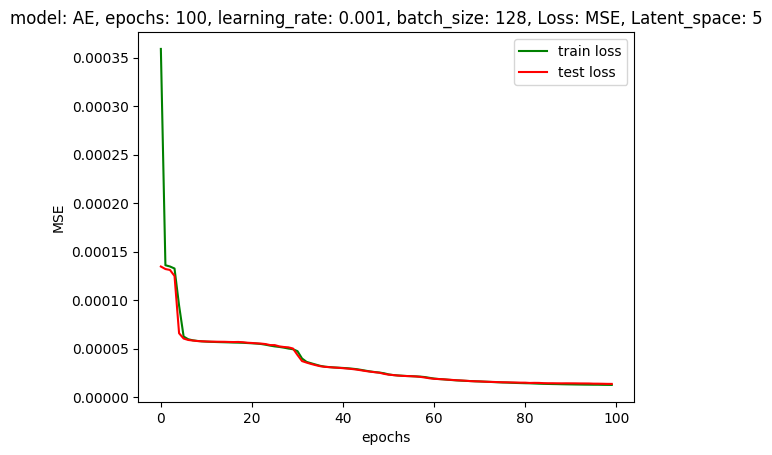

In [19]:
reduce_model.plot_loss()

In [20]:
main_reduced = reduce_model.transform(dataset)

array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
       [<Axes: title={'center': '2'}>, <Axes: title={'center': '3'}>],
       [<Axes: title={'center': '4'}>, <Axes: >]], dtype=object)

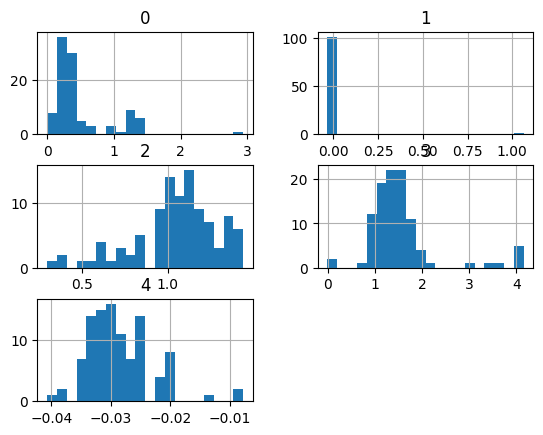

In [21]:
pd.DataFrame(main_reduced).hist(bins=20)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    main_reduced, target.values.ravel(), test_size=0.2, random_state=0)
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
       [<Axes: title={'center': '2'}>, <Axes: title={'center': '3'}>],
       [<Axes: title={'center': '4'}>, <Axes: >]], dtype=object)

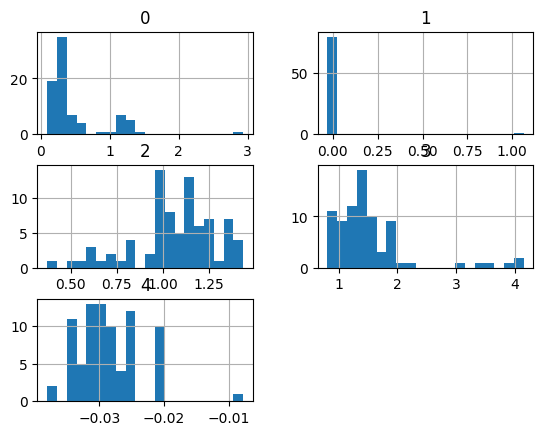

In [23]:
pd.DataFrame(X_train).hist(bins=20)

In [24]:
c_model = ClassifierModel()

In [25]:
res = c_model.cv(pd.DataFrame(X_train), pd.DataFrame(y_train))

evaluate CatBoost
  0%|          | 0/9223372036854775807 [00:00<?, ?trial/s, best loss=?]

  0%|          | 64/9223372036854775807 [00:10<403872038452374:11:12,  6.34trial/s, best loss: -0.6135265700483091]
evaluate LGM
  0%|          | 333/9223372036854775807 [00:10<76941826100548:51:12, 33.30trial/s, best loss: -0.38461538461538464] 
evaluate XGB
  0%|          | 204/9223372036854775807 [00:10<125591811500720:22:24, 20.40trial/s, best loss: -0.6761133603238865]
evaluate RF
  0%|          | 74/9223372036854775807 [00:10<347656075667609:14:40,  7.37trial/s, best loss: -0.5636363636363636]
evaluate AdaBoost
  0%|          | 67/9223372036854775807 [00:10<382487894017455:17:20,  6.70trial/s, best loss: -0.7333333333333334]


In [26]:
res

{'CatBoost': {'depth': 7,
  'l2_leaf_reg': 2.1284389222980313,
  'learning_rate': 0.0012848987326663447,
  'n_estimators': 75,
  'score': 0.8545454545454546,
  'balance': {'test': {'0.0': 11, '1.0': 5}, 'train': {'0.0': 42, '1.0': 23}}},
 'LGM': {'learning_rate': 3.23601829273348e-05,
  'max_depth': 5,
  'n_estimators': 84,
  'reg_lambda': 3.9385606194808367,
  'score': 0.4074074074074074,
  'balance': {'test': {'0.0': 11, '1.0': 5}, 'train': {'0.0': 42, '1.0': 23}}},
 'XGB': {'learning_rate': 0.0017417863220031949,
  'max_depth': 64,
  'n_estimators': 78,
  'reg_lambda': 1.1456687877895495,
  'score': 0.7681159420289856,
  'balance': {'test': {'0.0': 10, '1.0': 6}, 'train': {'0.0': 43, '1.0': 22}}},
 'RF': {'max_depth': 76,
  'n_estimators': 72,
  'score': 0.8131868131868132,
  'balance': {'test': {'0.0': 11, '1.0': 6}, 'train': {'0.0': 42, '1.0': 22}}},
 'AdaBoost': {'learning_rate': 1.0274381626910505e-05,
  'max_depth': 3,
  'n_estimators': 78,
  'score': 0.8785714285714286,
  'bal

In [27]:
c_model.set_params({name: {param: res[name][param] for param in res[name] if param not in ("balance", "score")} for name in res})

In [28]:
c_model.fit(X_train, y_train)

In [29]:
for name in c_model.models:
    print(f"report for {name}")
    print(metrics.classification_report(y_test, c_model.models[name].predict(X_test)))

report for CatBoost
              precision    recall  f1-score   support

         0.0       0.58      0.92      0.71        12
         1.0       0.50      0.11      0.18         9

    accuracy                           0.57        21
   macro avg       0.54      0.51      0.45        21
weighted avg       0.55      0.57      0.48        21

report for LGM
              precision    recall  f1-score   support

         0.0       0.57      1.00      0.73        12
         1.0       0.00      0.00      0.00         9

    accuracy                           0.57        21
   macro avg       0.29      0.50      0.36        21
weighted avg       0.33      0.57      0.42        21

report for XGB
              precision    recall  f1-score   support

         0.0       0.59      0.83      0.69        12
         1.0       0.50      0.22      0.31         9

    accuracy                           0.57        21
   macro avg       0.54      0.53      0.50        21
weighted avg       0.55 

C:\Users\droid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\droid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\droid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344